# Study region, site locations and model grids

In [9]:
import xarray as xr
import numpy as np
import xesmf as xe

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data/'
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

Wind and solar farms on ERA5 grid

In [2]:
solar_sites = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/solar_site_mask_era5.nc"
)["solar_site"]

In [3]:
wind_sites = xr.open_dataset(
    "/g/data/w42/dr6273/work/projects/Aus_energy/production_metrics/wind_site_mask_era5.nc"
)["wind_site"]

In [12]:
all_sites = solar_sites.sum("region") + wind_sites.sum("region")

ACCESS-ESM1-5 example file

In [23]:
model = xr.open_zarr(
    "/g/data/w42/dr6273/work/data/CMIP6/ACCESS-ESM1-5/historical/day/tas/tas_day_ACCESS-ESM1-5_historical_1950-2014.zarr/",
    consolidated=True
)["tas"].isel(member=0, time=0).drop(["time", "member"]).compute()

In [25]:
dlat = np.diff(model["lat"])[0]
dlon = np.diff(model["lon"])[0]

In [26]:
bnds_lat = [i - dlat / 2 for i in model["lat"].values]
bnds_lon = [i - dlon / 2 for i in model["lon"].values]

Regrid sites to model grid

In [27]:
regridder =  xe.Regridder(all_sites, model, "nearest_d2s")

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/xarray/core/dataarray.py:857: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data


In [28]:
model_sites = regridder(all_sites, keep_attrs=True)

/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:463: UserWarning: The .xlabels_bottom attribute is deprecated. Please use .bottom_labels to toggle visibility instead.
  warnings.warn('The .xlabels_bottom attribute is deprecated. Please '
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/g/data/w42/dr6273/apps/conda/envs/pangeo/lib/python3.10/site-packages/cartopy/mpl/gridliner.py:475: UserWarning: The .ylabels_left attribute is deprecate

Text(0.5, 1.0, 'ACCESS sites')

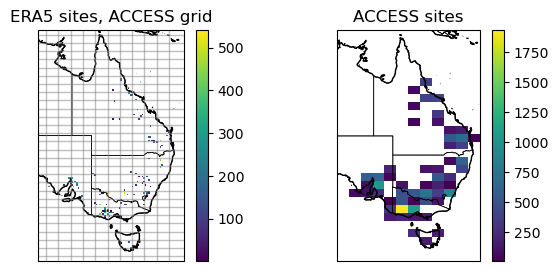

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(7, 3), subplot_kw={"projection": ccrs.PlateCarree()})

for a in ax:
    a.add_feature(
        cartopy.feature.NaturalEarthFeature(
            category='cultural',
            name='admin_1_states_provinces',
            scale='10m'
        ),
        facecolor='none',
        edgecolor='k',
        lw=.5,
        rasterized=True
    )
    a.coastlines()

all_sites.where(all_sites > 0).plot(ax=ax[0])
ax[0].set_title("ERA5 sites, ACCESS grid")

gl = ax[0].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='-')
gl.xlabels_top = False
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.ylabels_left = False
gl.xlocator = mticker.FixedLocator(bnds_lon)
gl.ylocator = mticker.FixedLocator(bnds_lat)

model_sites.where(model_sites > 0).plot(ax=ax[1])
ax[1].set_title("ACCESS sites")

Separately for wind and solar, write to file

In [30]:
# regridder =  xe.Regridder(wind_sites, model, "nearest_d2s")

In [34]:
model_sites_wind = regridder(wind_sites, keep_attrs=True).to_dataset(name="wind_site")
model_sites_solar = regridder(solar_sites, keep_attrs=True).to_dataset(name="solar_site")

In [35]:
model_sites_wind.to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/CMIP6/masks/ACCESS_wind_mask_NEM.nc"
)

In [36]:
model_sites_solar.to_netcdf(
    "/g/data/w42/dr6273/work/projects/Aus_energy/CMIP6/masks/ACCESS_solar_mask_NEM.nc"
)